## Applying Predictive Linear Models to Police Shootings.

The Washington post has a collection of police shootings from 2015 to present (found here: https://github.com/washingtonpost/data-police-shootings/blob/master/fatal-police-shootings-data.csv ). The data is very comprehensive, and the dataset itself is fairly clean. There is some treating to be done to clear out some of the NaN values, but otherwise this is a good dataset. 

This notebook will be broken down into four parts. We will start with treating the data. Afterwards we will break the data up into the train/validation/test, as well as define our targets and features. Then we will fit a few different models to the data and see what performs best. And finally, we will build some visualizations that can hopefully be used to explain our findings a bit more. 

In [2]:
#Load in the data:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_confusion_matrix
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
DATA_PATH = '../data/'
df = pd.read_csv(DATA_PATH+'/fatal-police-shootings-data.csv')
print(df.shape)
df.head()

(5408, 14)


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


### Section 1- Data Wrangling

The data in this section is pretty clean. Aside from a fair amount of NaN values scattered throughout the structure, there isn't a lot of noise here. 

In [3]:
#Choose your target. For this, I want to see if I can predict Race.
target = 'race'
print(df['race'].value_counts())
print(df['race'].isnull().sum())
df['race']
#This will be a Classification, there are 6 different races listed. 
#Baseline accuracy. White is the most common race, so its the baseline. 45.73% 
(2473 / 4890) * 100

W    2473
B    1296
H     902
A      93
N      78
O      48
Name: race, dtype: int64
518


50.57259713701432

In [66]:
def wrangle(X):
    X=X.copy()
    X['date'] = pd.to_datetime(X['date'], infer_datetime_format=True)
    cols_with_nans = ['armed','gender','flee']
    cols_for_age = ['age']
    for cols in cols_with_nans:
        X[cols] = X[cols].replace(np.nan, 'undetermined')
    mean = X['age'].dropna().sum() / len(X['age'])
    X['age'] = X['age'].replace(np.nan, mean)
    X['race'] =X['race'].replace('A', 'Asian')
    X['race'] =X['race'].replace('W','White')
    X['race'] =X['race'].replace('B','Black')
    X['race'] =X['race'].replace('N','Native')
    X['race'] =X['race'].replace('H','Hispanic')
    X['race'] =X['race'].replace('O','Other')
    X['armed'] = X['armed'].replace('gun and knife', 'gun')
    X['armed'] = X['armed'].replace('gun and car', 'gun')
    X['armed'] = X['armed'].replace('gun and vehicle', 'gun')
  
    return X
wrangled = wrangle(df)

In [67]:
wrangled['armed'].value_counts().head(20)

gun               3093
knife              792
undetermined       390
unarmed            352
toy weapon         185
vehicle            139
unknown weapon      79
machete             43
Taser               26
ax                  24
sword               22
baseball bat        18
hammer              16
sharp object        14
metal pipe          13
screwdriver         13
box cutter          12
hatchet             11
crossbow             9
scissors             7
Name: armed, dtype: int64

In [68]:
#I am not going to do any imputing into the race column, given that is our Target for these models.
#To avoid tainting the models, I will be dropping these rows and running from there.
wrangled.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                        0
age                          0
gender                       0
race                       518
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                         0
body_camera                  0
dtype: int64

In [69]:
print(wrangled.shape)
wrangled = wrangled.dropna()
wrangled.shape

(5408, 14)


(4890, 14)

## Section 2- Features and Targets

In my original exploration of this data, I tried to develop a few different features. However, while this was time consuming and illuminating, it also caused a great deal of leakage to enter the data. Without those engineered features, we only have 10 columns, but those will work for the model that we're creating here.

In [79]:
target = 'race'
columns_to_drop = ['id', 'name', 'date', 'race']
base, test = train_test_split(wrangled, test_size=.15, random_state=2)
train, val = train_test_split(base, test_size=.2, random_state=1)
train.shape, val.shape, test.shape

((3324, 14), (832, 14), (734, 14))

In [80]:
X_train = train.drop(columns=columns_to_drop, axis=1)
y_train = train[target]
X_val = val.drop(columns=columns_to_drop, axis=1)
y_val = val[target]
X_test = test.drop(columns=columns_to_drop, axis=1)
y_test = test[target]
X_train.shape, y_train.shape

((3324, 10), (3324,))

## Section 3- Selecting and Fitting the Models

This is a classification problem (as there are 6 racial demographics to pick from), and I will need two models to build around. I am going to select Logistic Regression for my linear model. And I will be going with XGBClassifier for my tree-based model. This will give me a wide range of answers and wide variety of visualizations to select from. For logistic regression, I'll be going with a pipeline, but for XGB I will be doing it manually since Shap doesn't like pipelines much.

In [81]:
log_pipeline = make_pipeline(ce.OrdinalEncoder(),
                             SimpleImputer(),
                             StandardScaler(),
                            LogisticRegression(max_iter=200))
log_pipeline.fit(X_train, y_train);
print('Train Accuracy:', log_pipeline.score(X_train, y_train))
print('Validation Accuracy:', log_pipeline.score(X_val, y_val))

Train Accuracy: 0.5403128760529483
Validation Accuracy: 0.5564903846153846


Logistic Regression beats the baseline without much tinkering, so that's solid. Now we're move on to XGB.

In [82]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [83]:
xgb = XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1)
xgb.fit(X_train_encoded, y_train)
print('Train Accuracy:', xgb.score(X_train_encoded, y_train))
print('Validation Accuracy:', xgb.score(X_val_encoded, y_val))
print('Test Accuracy:', xgb.score(X_test_encoded, y_test))

Train Accuracy: 0.6398916967509025
Validation Accuracy: 0.5264423076923077
Test Accuracy: 0.5258855585831063


XGB also beats the baseline without too much engineering. I wouldn't say that either of these models does its job particularly well, but they illustrate the points sufficiently.

## Section 4- Visualizations

For the build week, I will need 6 visualizations of the data. I will be doing the following:

1- Distribution

2- A Confusion Matrix for the Logistic Regression

3- Permutation Importances for the Logistic Regression

4- Partial Dependence Plot, 1 feature for XGB

5- Partial Dependence Plot, 2 features for XGB

6- Shapley Values for a randomly selected XGB row.

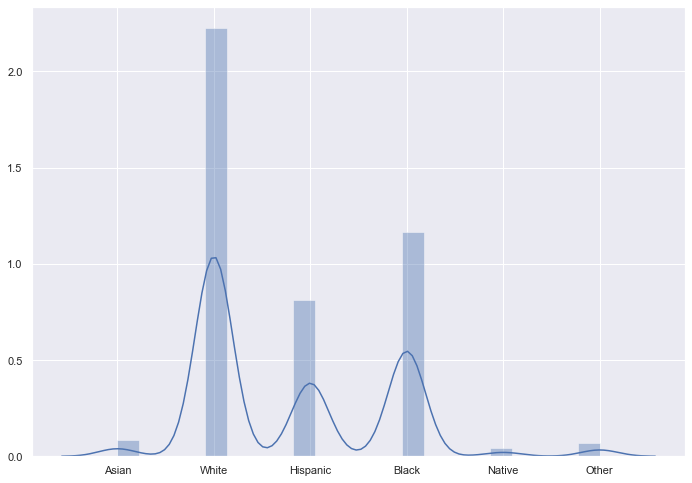

In [84]:
#Distribution Plot
import seaborn as sns
import matplotlib.pyplot as plt
y = df['race'].dropna()
encode_it = ce.OrdinalEncoder()
y_encoded = encode_it.fit_transform(y)
sns.set(rc={'figure.figsize':(11.7, 8.27)})
g = sns.distplot(y_encoded);
g.set(xticklabels= ['1','Asian','White','Hispanic','Black','Native','Other']);

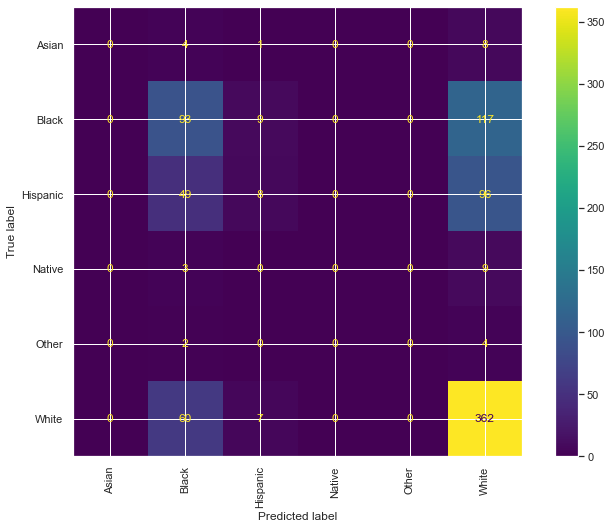

In [85]:
#Confusion Matrix
from matplotlib import rcParams
#rcParams['figure.figsize'] = 11.7,8.27

plot_confusion_matrix(log_pipeline, X_val, y_val, values_format='.0f',
                     xticks_rotation='vertical');

In [86]:
#Permutation Importances
pi = permutation_importance(xgb, X_val_encoded, y_val, random_state=1, n_jobs=-1)
pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [87]:
p_importance = pd.DataFrame({'feature': X_val.columns,
                            'weight': pi.importances_mean,
                            'std': pi.importances_mean})
p_importance.sort_values('weight', ascending=False).head(10)

,feature,weight,std
5,state,9.086538e-02,9.086538e-02
2,age,7.860577e-02,7.860577e-02
6,signs_of_mental_illness,1.322115e-02,1.322115e-02
4,city,8.653846e-03,8.653846e-03
9,body_camera,7.211538e-03,7.211538e-03
3,gender,2.163462e-03,2.163462e-03
8,flee,1.923077e-03,1.923077e-03
1,armed,4.440892e-17,4.440892e-17
0,manner_of_death,-4.807692e-04,-4.807692e-04
7,threat_level,-4.086538e-03,-4.086538e-03


In [88]:
import eli5
from eli5.sklearn import PermutationImportance
feature_names = X_val.columns.tolist()
permuter = PermutationImportance(xgb, scoring='accuracy',
                                n_iter=5, random_state=1)
permuter.fit(X_val_encoded, y_val)
eli5.show_weights(permuter, top=None, feature_names=feature_names)


Weight,Feature
0.0791 ± 0.0362,state
0.0716 ± 0.0096,age
0.0149 ± 0.0117,signs_of_mental_illness
0.0067 ± 0.0066,body_camera
0.0026 ± 0.0051,threat_level
0.0024 ± 0.0198,city
0.0012 ± 0.0015,gender
0.0007 ± 0.0106,flee
-0.0002 ± 0.0024,armed
-0.0002 ± 0.0010,manner_of_death


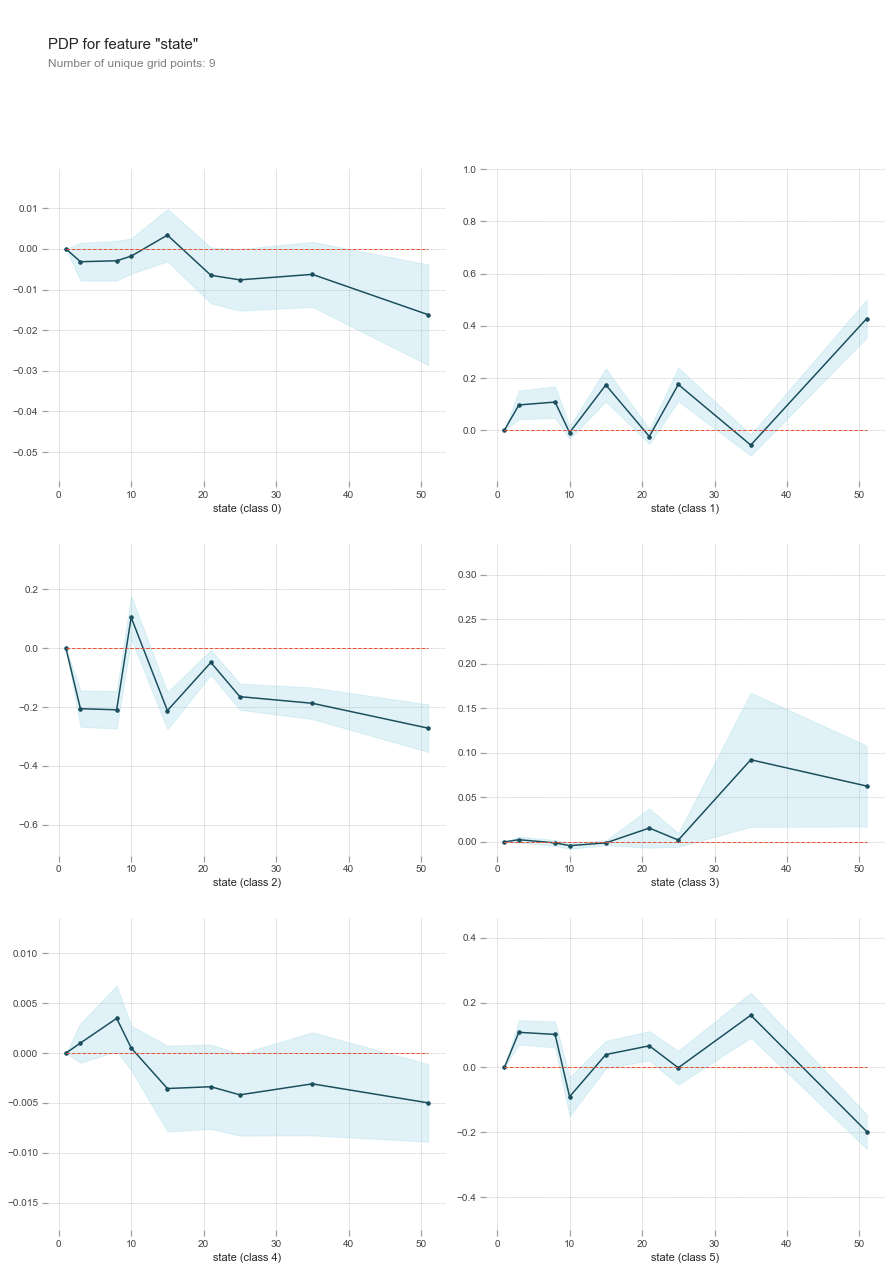

In [89]:
#PDP, 1 Feature
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'state'
features = X_train.columns
pdp_dist = pdp.pdp_isolate(model=xgb, dataset=X_train_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

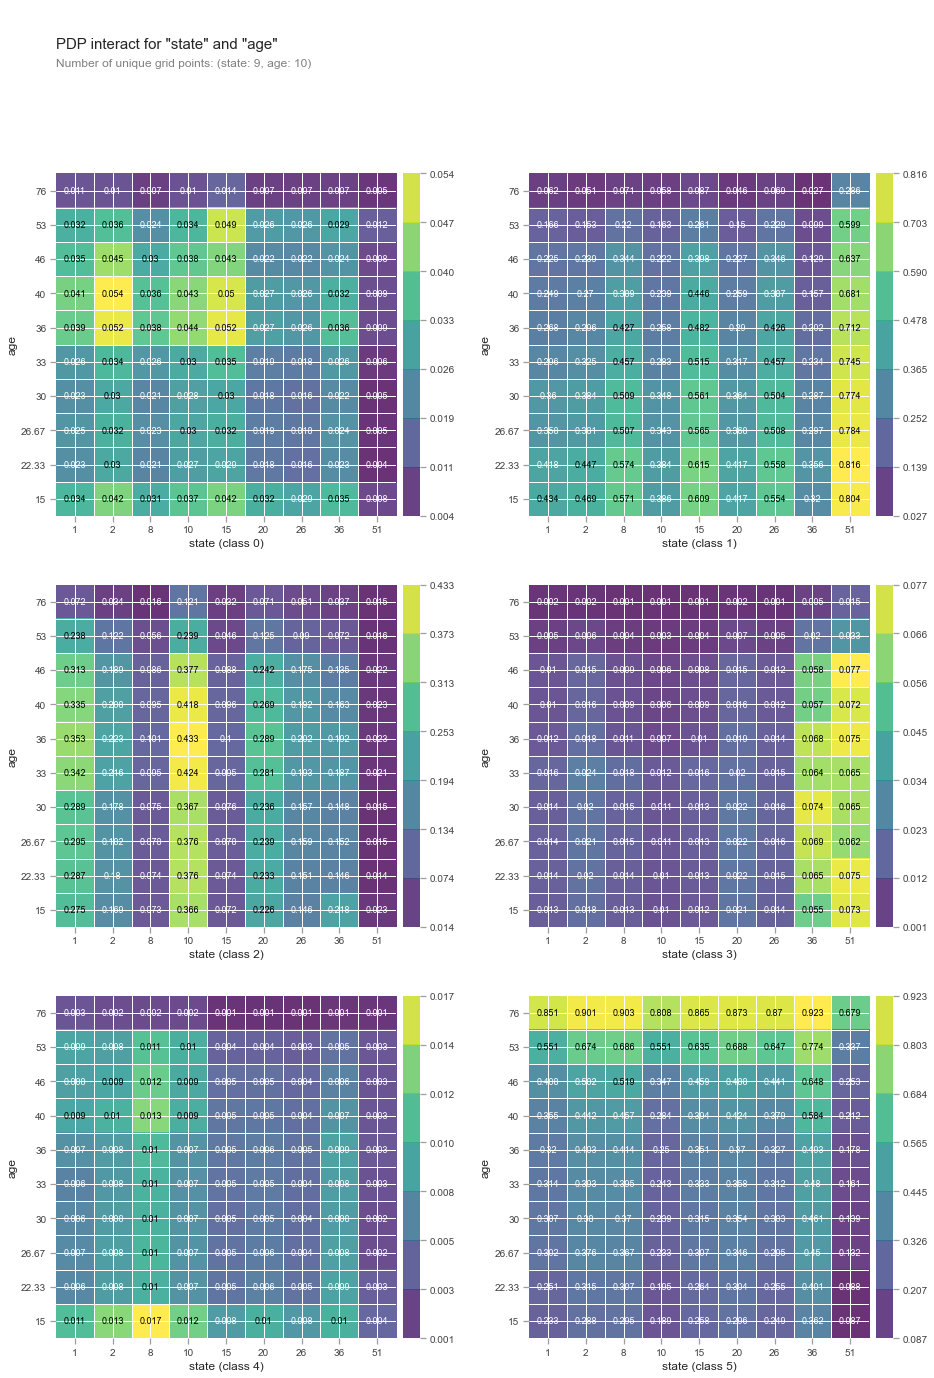

In [90]:
#PDP, 2 Features
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.inspection import permutation_importance
features = ['state', 'age']
interaction = pdp_interact(model=xgb,
                          dataset=X_val_encoded,
                          model_features=X_val_encoded.columns,
                          features=features)
pdp_interact_plot(interaction, plot_type='grid',feature_names=features);

In [91]:
model = XGBClassifier(n_estimators=100, random_state=1, n_jobs=-1)
model.fit(X_train_encoded, y_train)

XGBClassifier(n_jobs=-1, objective='multi:softprob', random_state=1)

In [92]:
import shap
row= X_test.iloc[[50]]
explainer = shap.TreeExplainer(model)
row_processed = encoder.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(base_value=explainer.expected_value[0],
                shap_values=shap_values[0],
                features=row,
                link='logit')

In [93]:
to_keep = ['race','state','age']
wrangled1 = wrangled[to_keep]
wrangled1.to_csv('wrangled1.csv')

In [94]:
import plotly.express as px
px.violin(wrangled1, y='race', x='age', color='race', box=True, points='all', hover_data=wrangled1.columns)


In [95]:
px.violin(wrangled1, y='race', x='state', color='race', box=True, points='all', hover_data=wrangled1.columns)

In [96]:
from joblib import dump
dump(log_pipeline, 'pipeline.joblib', compress=True)

['pipeline.joblib']

In [97]:
cat = log_pipeline.named_steps['ordinalencoder'].mapping[3]
cat

{'col': 'city',
 'mapping': Houston           1
 Vancouver         2
 Gastonia          3
 Fort Wayne        4
 Hawkins           5
                ... 
 Refugio        1741
 Medina         1742
 Lake City      1743
 Lake Hallie    1744
 NaN              -2
 Length: 1745, dtype: int64,
 'data_type': dtype('O')}